In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.combine import SMOTEENN
import plotly.express as px

In [2]:
# load the data and reset index of dataframe
df: pd.DataFrame = pd.read_pickle(
    "../training_dataset_task3/task_3_training_e8da4715deef7d56_f8b7378_pandas.pkl").reset_index()

# get only the low and mid level features + segment_id
X = df.loc[:, "essentia_dissonance_mean":"mirtoolbox_roughness_pct_90"]
# target value
y = df["quadrant"]

# preprocess dataset
X_std = StandardScaler().fit_transform(X)
X = pd.DataFrame(X_std, columns=X.columns)

In [3]:
# get features that have a correlation above some threshold
from itertools import combinations

corr_df = X.corr()

feature_combis = combinations(corr_df.columns, 2)
n_combis = len(list(combinations(corr_df.columns, 2)))

corr_features = []

for f1, f2 in feature_combis:
    corr = corr_df[f1].loc[f2]
    
    # strong
    if 0.9 <= abs(corr):
        corr_features.append(dict([("corr", corr), ("feature 1", f1), ("feature 2", f2)]))

corr_features_df = pd.DataFrame(corr_features)

In [4]:
# top 5 positive correlation
corr_features_df.sort_values(by=["corr"], ascending=False).head(5)

,corr,feature 1,feature 2
18,0.997793,librosa_mfcc_mean_0,librosa_mfcc_pct_50_0
87,0.995234,mirtoolbox_roughness_mean,mirtoolbox_roughness_pct_50
35,0.995038,librosa_mfcc_mean_2,librosa_mfcc_pct_50_2
55,0.994096,librosa_mfcc_mean_6,librosa_mfcc_pct_50_6
60,0.992734,librosa_mfcc_mean_7,librosa_mfcc_pct_50_7


In [5]:
# top 5 negative correlation
corr_features_df.sort_values(by=["corr"], ascending=True).head(5)

,corr,feature 1,feature 2
75,-0.939749,midlevel_features_dissonance,midlevel_features_tonal_stability
74,-0.931481,midlevel_features_melody,midlevel_features_dissonance
53,0.900357,librosa_mfcc_pct_50_5,librosa_mfcc_pct_90_5
13,0.901168,librosa_chroma_std_8,librosa_chroma_pct_90_8
85,0.901781,mirtoolbox_novelty_std,mirtoolbox_novelty_pct_90


In [6]:
# add segment_id to data for filtering segments
X["segment_id"] = df["segment_id"]

In [7]:
# remove segment_id 26 and keep as test/ eval data for later
seg_26_indices = (X["segment_id"] == 26)
X_test = X[seg_26_indices].drop(["segment_id"], axis=1)
y_test = y[seg_26_indices]

X_train = X.drop(X[seg_26_indices].index, axis=0).reset_index(drop=True)
y_train = y.drop(X[seg_26_indices].index, axis=0)

In [8]:
# Combination of over- and under-sampling
# https://imbalanced-learn.org/stable/combine.html
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
# X_resampled, y_resampled = X_train, y_train

In [9]:
# split the data according to segment_id
# store the splits as tuple (train indices, test_indices)
# 2 segments for test, the rest for training (not including segment 26)
cv = []

for i in range(24):
    train_indices = X_resampled[~X_resampled["segment_id"].isin([i, i + 1])].index.to_list()
    test_indices = X_resampled[X_resampled["segment_id"].isin([i, i + 1])].index.to_list()
    cv.append((train_indices, test_indices))

In [10]:
# remove the segment_id as we don't want it in the training data
X_resampled = X_resampled.drop(["segment_id"], axis=1)

In [11]:
# select k best features according to ANOVA F-value between label/feature (for classification tasks)
best_features = SelectKBest(score_func=f_classif, k=15).fit(X_resampled, y_resampled).get_feature_names_out()
X_select = X_resampled[best_features]

# kNN

In [67]:
# parameters for grid search
params = {
    "n_neighbors": np.linspace(1, 300, 150, dtype=int).tolist(),
    "weights": ["uniform"],  # {‘uniform’, ‘distance’}
    "algorithm": ["auto"],  # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
}

gs_cv = GridSearchCV(KNeighborsClassifier(), params, cv=cv, return_train_score=True, n_jobs=-1)
gs_cv.fit(X_select, y_resampled)
print(gs_cv.best_score_, gs_cv.best_params_)

0.5491609243462987 {'algorithm': 'auto', 'n_neighbors': 77, 'weights': 'uniform'}


In [68]:
# results of the Grid Search CV
cv_results = pd.DataFrame.from_dict(gs_cv.cv_results_)
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,...,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,mean_train_score,std_train_score
0,0.007885,0.002679,0.007126,0.003206,auto,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.396226,0.47561,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.007364,0.002554,0.007638,0.002641,auto,3,uniform,"{'algorithm': 'auto', 'n_neighbors': 3, 'weigh...",0.358491,0.45122,...,0.922633,0.912568,0.906667,0.907850,0.918478,0.922423,0.912859,0.924755,0.913442,0.006392
2,0.007166,0.002049,0.006912,0.002005,auto,5,uniform,"{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.358491,0.50000,...,0.877598,0.862295,0.850000,0.853242,0.869565,0.870351,0.858661,0.872410,0.864740,0.007428
3,0.006695,0.001479,0.007362,0.002826,auto,7,uniform,"{'algorithm': 'auto', 'n_neighbors': 7, 'weigh...",0.320755,0.47561,...,0.834873,0.832787,0.818889,0.813424,0.834783,0.843783,0.828905,0.838604,0.833123,0.010003


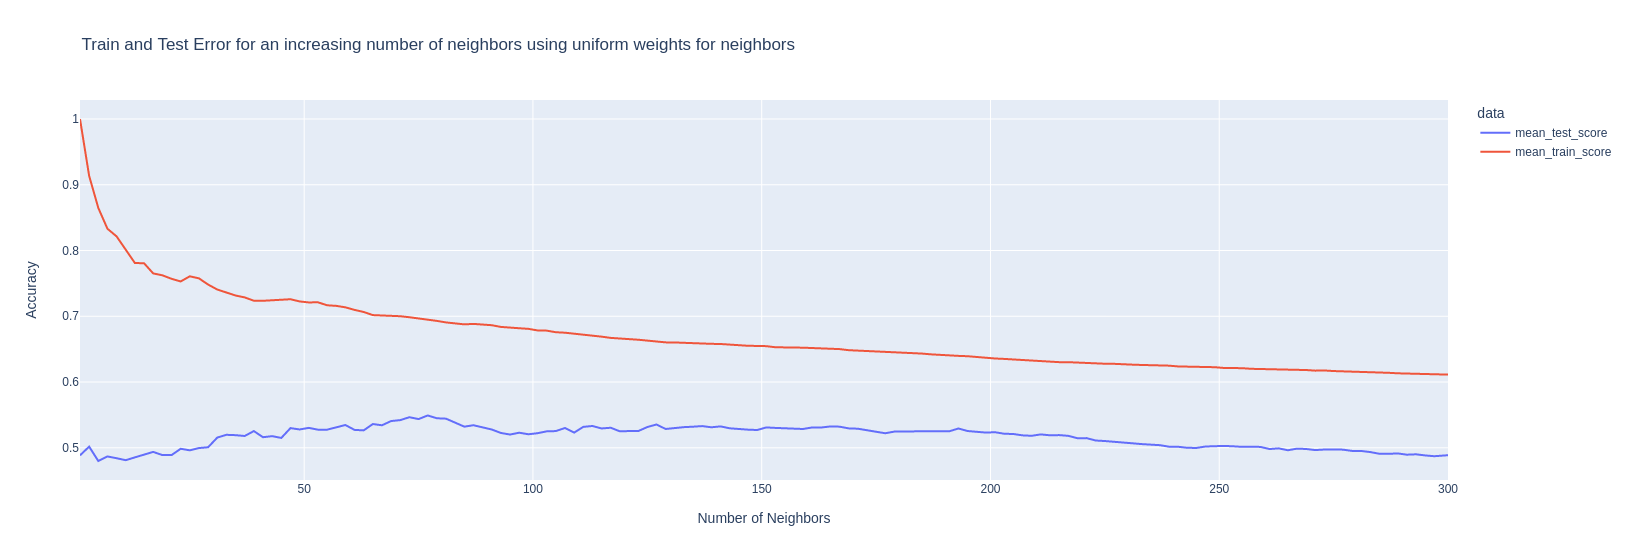

In [70]:
# plot the train and test error against number of neighbors
fig = px.line(
    cv_results,
    x="param_n_neighbors",
    y=["mean_test_score", "mean_train_score"],
    title="Train and Test Error for an increasing number of neighbors using uniform weights for neighbors",
    labels={
        "param_n_neighbors": "Number of Neighbors",
        "mean_test_score": "Mean Test Score",
        "mean_train_score": "Mean Train Score",
        "value": "Accuracy",
        "variable": "data"
    },
    width=800*1.4,
    height=400*1.4,
)
fig.update_traces(mode="lines")
fig.show()

In [15]:
# score on held out test set, segment 26
gs_cv.score(X_test[best_features], y_test)

0.43023255813953487

# Naive bayes

In [72]:
from sklearn.naive_bayes import GaussianNB

In [73]:
gs_cv_nb = GridSearchCV(GaussianNB(), {}, cv=cv, return_train_score=True, n_jobs=-1)
gs_cv_nb.fit(X_select, y_resampled)
print(gs_cv_nb.best_score_, gs_cv_nb.best_params_)

0.5291597107236847 {}


In [74]:
# results of the Grid Search CV
cv_results_nb = pd.DataFrame.from_dict(gs_cv_nb.cv_results_)
cv_results_nb.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,mean_train_score,std_train_score
0,0.005506,0.001051,0.001824,0.000336,{},0.509434,0.52439,0.557377,0.512195,0.272727,...,0.613164,0.6,0.575556,0.59727,0.621739,0.594049,0.585547,0.581243,0.600897,0.016904


In [75]:
gs_cv_nb.score(X_test[best_features], y_test)

0.27906976744186046

In [76]:
splits = []
split_score_train = []
split_score_test = []
for i in range(24):
    splits.append(f"split {i}")
    split_score_train.append(cv_results_nb[f"split{i}_train_score"].values[0])
    split_score_test.append(cv_results_nb[f"split{i}_test_score"].values[0])
    
dic = {"splits": splits, "train_score": split_score_train, "test_score": split_score_test}
res_nb = pd.DataFrame.from_dict(dic)
res_nb

,splits,train_score,test_score
0,split 0,0.599366,0.509434
1,split 1,0.609597,0.524390
2,split 2,0.607676,0.557377
3,split 3,0.606472,0.512195
4,split 4,0.614148,0.272727
5,split 5,0.635227,0.268908
6,split 6,0.638106,0.392857
7,split 7,0.597838,0.648649
8,split 8,0.593453,0.730769
9,split 9,0.603715,0.433333


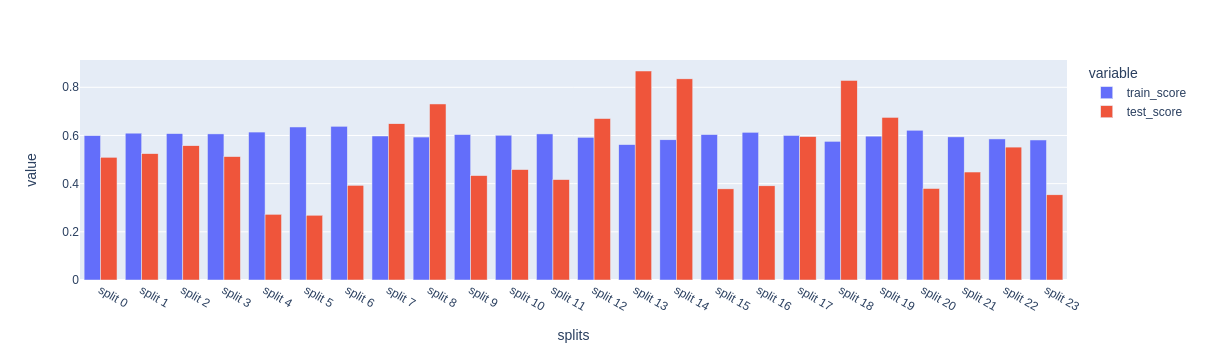

In [77]:
nb = px.bar(res_nb, x="splits", y=["train_score","test_score"]  ,  barmode="group")
nb.show()

# Baseline classifier that always predicts the same class

In [16]:
from sklearn.base import BaseEstimator

class AlwaysY(BaseEstimator):
    def __init__(self, y=1):
        self.y = y

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        res = np.ones(shape=X.shape[0]) * self.y
        return res

In [17]:
# get only the low and mid level features + segment_id
X_base = df.loc[:, "essentia_dissonance_mean":"mirtoolbox_roughness_pct_90"]
# add segment_id to data for filtering segments
X_base["segment_id"] = df["segment_id"]
# target value
y_base = df["quadrant"]


# split the data according to segment_id
# store the splits as tuple (train indices, test_indices)
# 2 segments for test, the rest for training (not including segment 26)
cv_base = []

for i in range(24):
    train_indices = X_base[~X_base["segment_id"].isin([i, i + 1])].index.to_list()
    test_indices = X_base[X_base["segment_id"].isin([i, i + 1])].index.to_list()
    cv_base.append((train_indices, test_indices))

In [18]:
gs_cv_base = GridSearchCV(AlwaysY(), {"y": [1,2,3,4]}, cv=cv_base, return_train_score=True,scoring="accuracy", n_jobs=-1)
gs_cv_base.fit(X_base, y_base)
print(gs_cv_base.best_score_, gs_cv_base.best_params_)

0.27831793674370336 {'y': 4}


In [19]:
# results of the Grid Search CV for base classifier
base_results = pd.DataFrame.from_dict(gs_cv_base.cv_results_)
base_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_y,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,mean_train_score,std_train_score
0,0.007743,0.001253,0.000387,0.000065,1,{'y': 1},0.204444,0.497561,0.394904,0.331081,...,0.226603,0.211547,0.211556,0.213107,0.210726,0.230170,0.232936,0.228679,0.216062,0.011012
1,0.008459,0.001438,0.000477,0.000250,2,{'y': 2},0.088889,0.136585,0.216561,0.270270,...,0.183848,0.174596,0.173794,0.171861,0.193640,0.206326,0.186158,0.182755,0.184158,0.015087
2,0.008214,0.001168,0.000449,0.000067,3,{'y': 3},0.373333,0.185366,0.242038,0.256757,...,0.249406,0.284988,0.284804,0.283685,0.281443,0.263260,0.263484,0.288660,0.278542,0.016418
3,0.006299,0.001300,0.000363,0.000058,4,{'y': 4},0.333333,0.180488,0.146497,0.141892,...,0.340143,0.328868,0.329845,0.331347,0.314191,0.300243,0.317422,0.299906,0.321239,0.019838


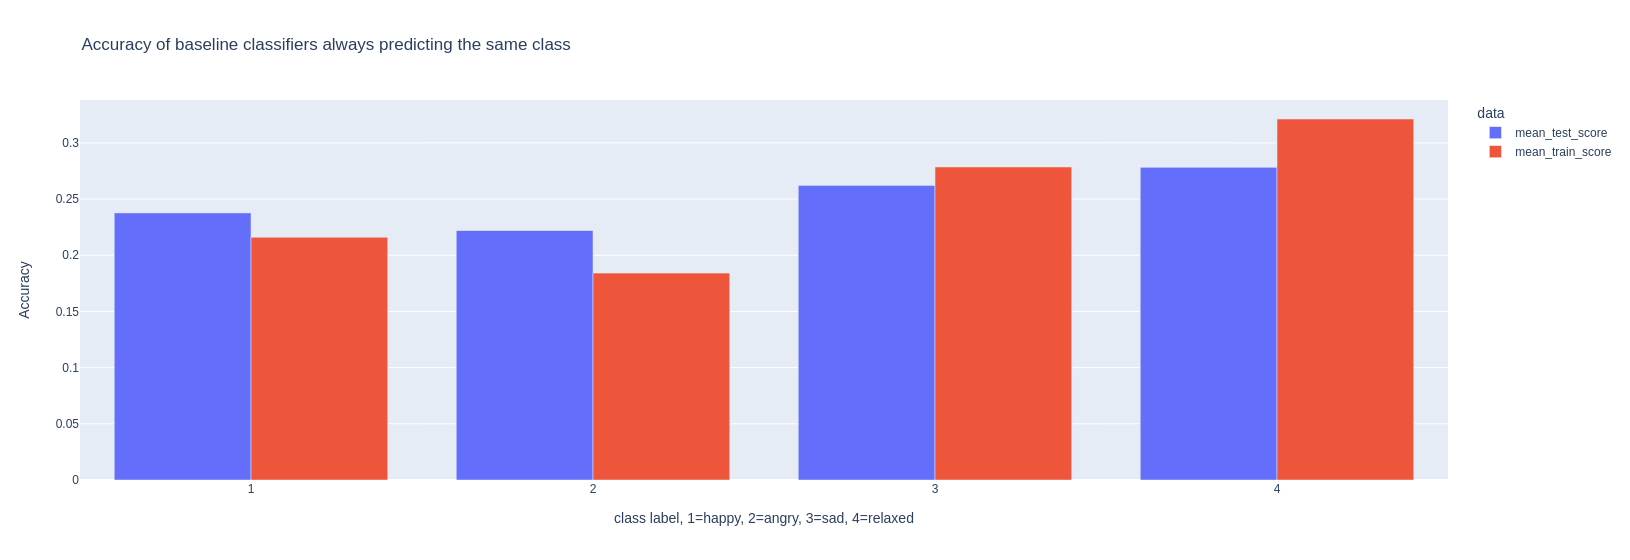

In [71]:
bar = px.bar(
    base_results,
    x="param_y",
    y=["mean_test_score", "mean_train_score"],
    barmode="group",
    title="Accuracy of baseline classifiers always predicting the same class",
    labels={
        1: "happy (1)",
        "2": "angry (2)",
        "3": "sad (3)",
        "4": "relaxed (4)",
        "param_y": "class label, 1=happy, 2=angry, 3=sad, 4=relaxed",
        "mean_test_score": "Mean Test Score",
        "mean_train_score": "Mean Train Score",
        "value": "Accuracy",
        "variable": "data"
    },
    width=800*1.4,
    height=400*1.4,
)
bar.show()

In [21]:
# score on held out test set, segment 26
gs_cv_base.score(X_test[best_features], y_test)

0.29069767441860467

In [24]:
y_test[y_test == 4].shape

(25,)

In [25]:
y_test.shape

(86,)

In [26]:
25/86

0.29069767441860467